<a href="https://colab.research.google.com/github/ssunggun2/2022_dacon_NLI/blob/main/Dacon_NLI_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인스톨

In [22]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 5.4 MB/s 
     |████████████████████████████████| 448 kB 47.4 MB/s 


# 구글 코랩 마운트

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

# 패키지 불러오기 및 폰트 설정

In [23]:
import os
import pandas as pd
from zipfile import ZipFile
from google.colab import data_table
from glob import glob
import numpy as np
from tqdm import tqdm, tqdm_notebook

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

data_table.enable_dataframe_formatter()

In [21]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


# 자료 불러오기

In [15]:
zip_dir = '/content/drive/MyDrive/화요일 스터디 폴더/dacon'
zip_name = 'open.zip'
zip_fPath = os.path.join(zip_dir, zip_name)

with ZipFile(zip_fPath, 'r') as zip:
    zip.printdir()
    zip.extractall() 

File Name                                             Modified             Size
open/sample_submission.csv                     2022-01-25 15:19:44        18894
open/test_data.csv                             2022-01-25 15:19:46       320363
open/train_data.csv                            2022-01-25 17:30:34      4855176


In [25]:
train = pd.read_csv('/content/open/train_data.csv')
test = pd.read_csv('/content/open/test_data.csv')
submission = pd.read_csv('/content/open/sample_submission.csv')
train.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [27]:
print(f"train_shape : {train.shape}")
print(f"test_shape : {test.shape}")
print(f"submission_shape : {submission.shape}")

train_shape : (24998, 4)
test_shape : (1666, 4)
submission_shape : (1666, 2)


# 데이터 시각화

## train target 분포 확인

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


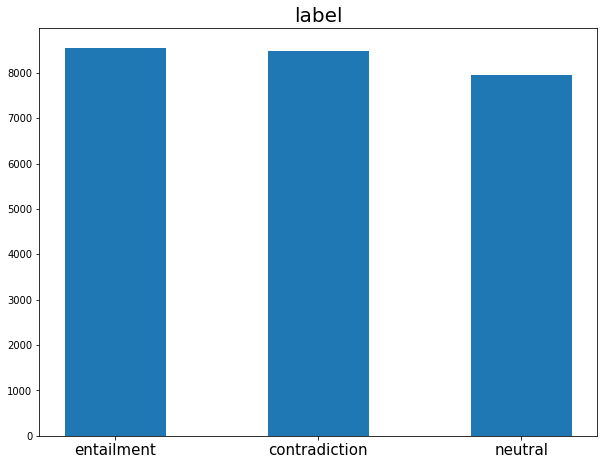

In [29]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅시다
feature = train["label"]

plt.figure(figsize = (10,7.5)) # 그래프 이미지 크기 설정

plt.title('label', fontsize = 20)
temp = feature.value_counts()  # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize = 15)
plt.show()